In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so 
import pymc as pm
import pytensor.tensor as pt
import arviz as az

rng = np.random.RandomState(123)



In [6]:
%matplotlib inline

In [7]:
# ReAd_ground the Excel file
test_point_locations = pd.read_excel('Shot_training_record.xlsx')

# Display the dataframe
#print(test_point_locations)

# ReAd_ground the Excel file and get the second tab
test_data = pd.read_excel('Shot_training_record.xlsx', sheet_name=1)
#test_data = test_data.dropna()
# Display the dataframe
print(test_data)
data_qty = len(test_data)
print("There are this many data points:" , data_qty)



     shot number  point  arm angle  actual arm angle  Ad (m)  \
0              1      2      320.0               NaN     NaN   
1              2      2      300.0               NaN     NaN   
2              3      2      310.0               NaN     NaN   
3              4      2      308.0               NaN     NaN   
4              5      2      308.0               NaN     NaN   
..           ...    ...        ...               ...     ...   
134          135      8      309.0             308.5    2.07   
135          136      8      315.0             314.4     NaN   
136          137      8      315.0             314.4     NaN   
137          138      8      315.0             314.4     NaN   
138          139      8      315.0             314.4     NaN   

     To_Side_angle (limelight)  x off center of hole  z off hole edges  \
0                          NaN                     0                25   
1                          NaN                     0               -35   
2        

# Learn To Shoot

Target on the wall above april tags.

projectile is an approximatly 12in diameter donut.

Robot on feild, with angeled arm, at end of arm are in-line flaps

Robot has limelight vision above the front bumper. it can identify april tags and report the ???

In [8]:
def angle_to_radian(angle):
    return angle * np.pi / 180

In [9]:
miss_tol = test_data['arm angle']-270
print(pm.math.sin(angle_to_radian(miss_tol)).eval())
time  = 0.5
init_vel = 450/(.71-.29)

init_vel * pm.math.sin(angle_to_radian(miss_tol)).eval() * time - 0.5 * 9.8 * 100 * time**2

[0.76604444 0.5        0.64278761 0.61566148 0.61566148 0.61566148
 0.57357644 0.59482279 0.61566148 0.61566148 0.61566148 0.61566148
 0.61566148 0.61566148 0.61566148 0.61566148 0.58778525 0.58778525
 0.58778525 0.58778525 0.60181502 0.60181502 0.60181502 0.60181502
 0.81915204 0.81915204 0.81915204 0.5        0.60181502 0.57357644
 0.54463904 0.52991926 0.53729961 0.53729961 0.53729961 0.53729961
 0.53729961 0.53729961 0.53729961 0.53729961 0.53729961 0.53729961
 0.53729961 0.53729961 0.5        0.40673664 0.40673664 0.40673664
 0.5        0.5        0.5        0.52991926 0.52991926 0.54463904
 0.53729961 0.53729961 0.53729961 0.53729961 0.53729961 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.60181502
 0.60181502 0.60181502 0.60181502 0.59482279 0.59482279 0.59482279
 0.59482279 0.59482279 0.53729961 0.59482279 0.59482279 0.59482279
 0.59482279 0.59482279 0.59482279 0.59482279 0.59482279 0.59482279
 0.594822

array([287.88095167, 145.35714286, 221.85050519, 207.3186475 ,
       207.3186475 , 207.3186475 , 184.7730909 , 196.15506433,
       207.3186475 , 207.3186475 , 207.3186475 , 207.3186475 ,
       207.3186475 , 207.3186475 , 207.3186475 , 207.3186475 ,
       192.38495659, 192.38495659, 192.38495659, 192.38495659,
       199.90090526, 199.90090526, 199.90090526, 199.90090526,
       316.3314523 , 316.3314523 , 316.3314523 , 145.35714286,
       199.90090526, 184.7730909 , 169.27091162, 161.38532012,
       165.3390759 , 165.3390759 , 165.3390759 , 165.3390759 ,
       165.3390759 , 165.3390759 , 165.3390759 , 165.3390759 ,
       165.3390759 , 165.3390759 , 165.3390759 , 165.3390759 ,
       145.35714286,  95.39463022,  95.39463022,  95.39463022,
       145.35714286, 145.35714286, 145.35714286, 161.38532012,
       161.38532012, 169.27091162, 165.3390759 , 165.3390759 ,
       165.3390759 , 165.3390759 , 165.3390759 , 145.35714286,
       145.35714286, 145.35714286, 145.35714286, 145.35

30
0.49999999999999994


c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


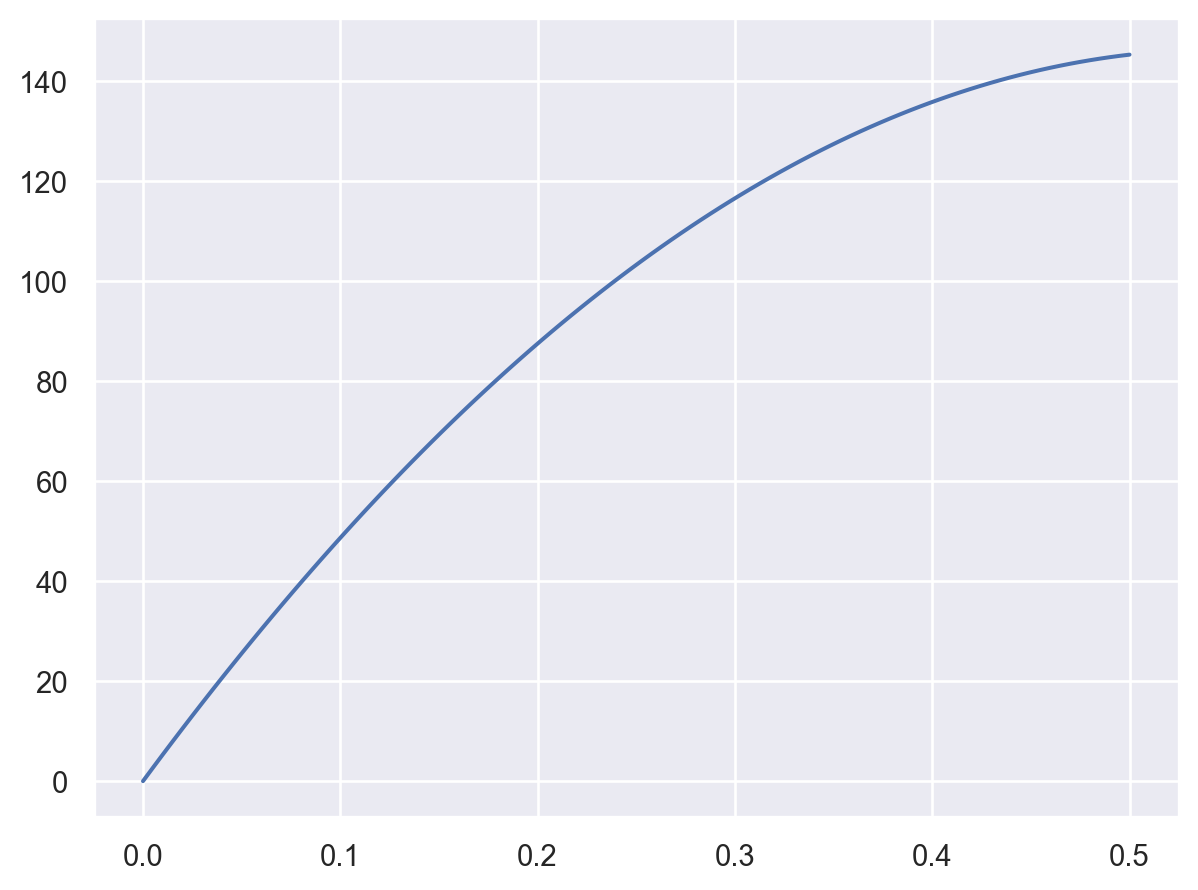

In [10]:
miss_tol = 300-270
print(miss_tol)
print(pm.math.sin(angle_to_radian(miss_tol)).eval())
time  = np.linspace(0, 0.5, 100)
init_vel = 450/(.71-.29)

h = init_vel * pm.math.sin(angle_to_radian(miss_tol)).eval() * time - 0.5 * 9.8 * 100 * time**2

(
    so.Plot(x=time, y=h)
    .add(so.Line())
)

In [30]:



with pm.Model() as generate:
    #Coords
    generate.add_coord('samples', test_data['shot number'], mutable=True)
    generate.add_coord('position', test_data.point, mutable=True)
    
    # Priors
    h_miss_sigma = pm.HalfNormal('h_miss_sigma', sigma=10)
    deltaVo = pm.Normal('deltaVo', sigma=10)  # deltaVo is the conv to effective velocity of the shooter
    deltaA = pm.Normal('DeltaA', sigma=np.pi/(12), transform=pm.distributions.transforms.circular)  # BetaA is the uncertainty to effective angle of the arm from the center line of the shooter

    #Constants
    La = pm.MutableData('La', 56)  # length of arm in cm    
    g = pm.MutableData('g', 9.81)  # gravity in m/s^2
    Th = pm.MutableData('Th', 199+13/2)  # height of target in cm
    Ah = pm.MutableData('Ah',146)  # height of april tag in meters

    # Data mutable

    h_miss_record = pm.MutableData('h_miss_record', test_data['Adj Z miss'], dims='samples')  # height of miss in cm
    Ad_ground = pm.MutableData('Ad_ground', test_data['Expected Radial dist'], dims='samples')
    Vo_rec = pm.MutableData('Vo_rec', 450/(.71-.29))#, dims='samples') #cm/sec
    #Not certain about Vo
    Vo = pm.Deterministic('Vo_maybe', Vo_rec + deltaVo)
    alphaA_set = pm.MutableData('alphaA_set', test_data['arm angle']-270, dims='samples')#, transform='circular') # Ad_groundjusted by 270 for arm 0 being straight up
    alphaA = pm.Deterministic('alphaA', alphaA_set + deltaA, dims='samples')

    # use pathagorean theorem to solve for ground distance from april tag
    # d = sqrt(Ad_ground^2 - Ah^2); Ad_ground is straight line hypthosnuse, Ah is height of april tag
    #TODO: check if this is the correct way to calculate d... limelight may be returning the ground distance
    d = pm.math.sqrt( Ad_ground ** 2 + Ah ** 2)
    #d_out = pm.Deterministic('d_out', d, dims='samples')
    # trajectory equation solved for time
    # d = Vo * cos(theta) * t
    t = d / (Vo * pm.math.cos(angle_to_radian(alphaA)))
    #t_out = pm.Deterministic('t_out', t, dims='samples')
    # trajectory equation solved for height
    # h = Vo * sin(theta) * t - 0.5 * g * t**2
    h = Vo * pm.math.sin(angle_to_radian(alphaA)) * t - 0.5 * 100 * g * t ** 2 #convert g from m/s2 to cm/s2 
    #h_out = pm.Deterministic('h_out', h, dims='samples')

    # Shooter height using length of arm (La) and angle of arm (alphaA)
    Sh = La * pm.math.sin(angle_to_radian(alphaA))
    Th_sim =  h + Sh
    #Th_sim_out = pm.Deterministic('Th_sim_out', Th_sim, dims='samples')
    h_missDist = pm.Deterministic('h_missDist',  Th_sim - Th, dims='samples')
    #liklihood function for the height miss
    h_miss = pm.Normal('h_miss', mu=h_missDist, sigma=h_miss_sigma, observed=h_miss_record, dims='samples')

    include_side_error = False
    if include_side_error:
        x_miss_sigma = pm.HalfNormal('x_miss_sigma', sigma=5)
        x_miss_record = pm.MutableData('x_miss_record', test_data['x off center of hole'], dims='samples')  # x distance miss on target
        x = pm.MutableData('x', test_data['Point Position on field_x'], dims='samples')  # distance from april tag centerline along driverstation wall
        y = pm.MutableData('y', test_data['Point Position on field_y'], dims='samples')  # distance from april tag face out from driverstation wall
        gammaF = pm.HalfNormal('gammaF',  sigma=1)  # gammaF is the uncertainty to effective flap angle of the flaps from the center line of the shooter; assuming equal on both sides
        alphaF_left = pm.MutableData('alphaF_left', test_data['left flap angle'], dims='samples')#, transform='circular')
        #alphaF_right = pm.MutableData('alphaF_right', test_data['right flap angle'], dims='samples')#, transform='circular')
        #for now assume same angle for both flaps
        alphaF = alphaF_left  #
        alphaR = pm.MutableData('alphaR', test_data['Robot angle'], dims='samples')#, transform='circular') # angle of the robot releative to the y axis
        # angular error to leAd_ground to horizontal error
        # Talpha is the angle of the target from the center of the shooter
        alphaFprime = gammaF * angle_to_radian(alphaF) * (1 - angle_to_radian(alphaA) / np.pi)
        alphaTraj = alphaR + alphaFprime

        # true horizontal angle to the target
        Talpha = pt.arctan(x/y)
        
        # simplify miss distance as horiz arc length using the string length to the target
        x_missDist = angle_to_radian(Talpha - alphaTraj) * pm.math.sqrt(h ** 2 + d ** 2)
        #liklihood function for the x miss
        x_miss = pm.Normal('x_miss', mu=x_missDist, sigma=x_miss_sigma, observed=x_miss_record, dims='samples')





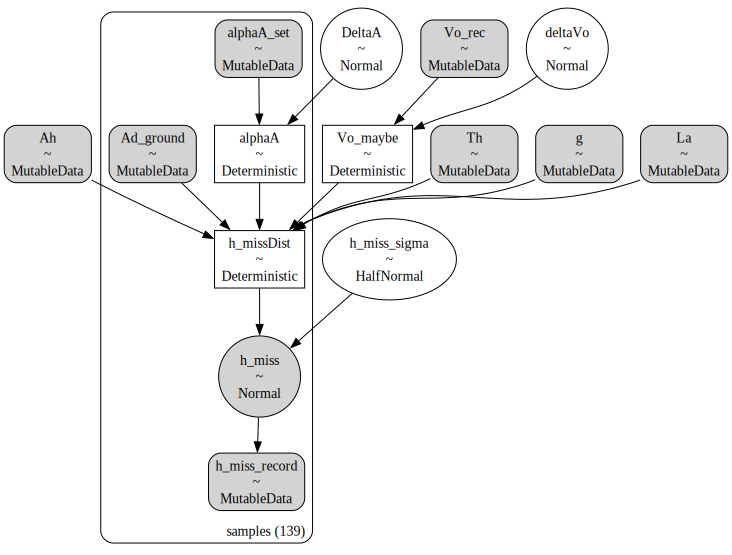

In [31]:
pm.model_to_graphviz(generate)

In [32]:
idata = pm.sample_prior_predictive(model=generate, samples=1000)

Sampling: [DeltaA, deltaVo, h_miss, h_miss_sigma]


c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\willi\anaconda3\envs\pymc_01Oct23_py311\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


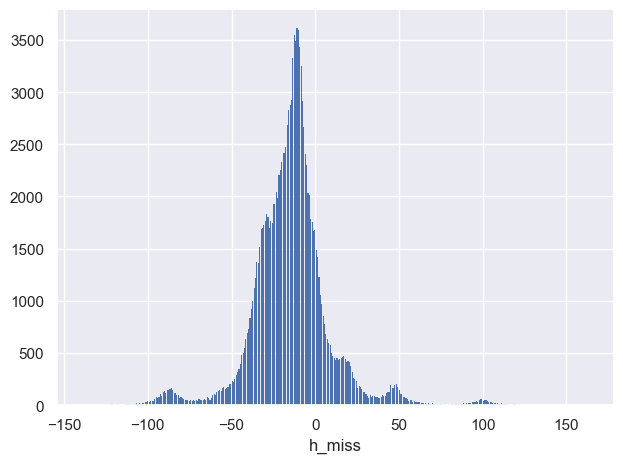

In [35]:
(
    so.Plot(idata.prior_predictive.to_dataframe().dropna(), x= 'h_miss')
    .add(so.Bar(), so.Hist())
    .show()
)

In [36]:
idata.extend(pm.sample(model=generate, draws=1000, tune=1000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h_miss_sigma, deltaVo, DeltaA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [37]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [38]:
generate.debug(verbose=True)

point={'h_miss_sigma_log__': array(2.30258509), 'deltaVo': array(0.), 'DeltaA_circular__': array(0.)}

No problems found


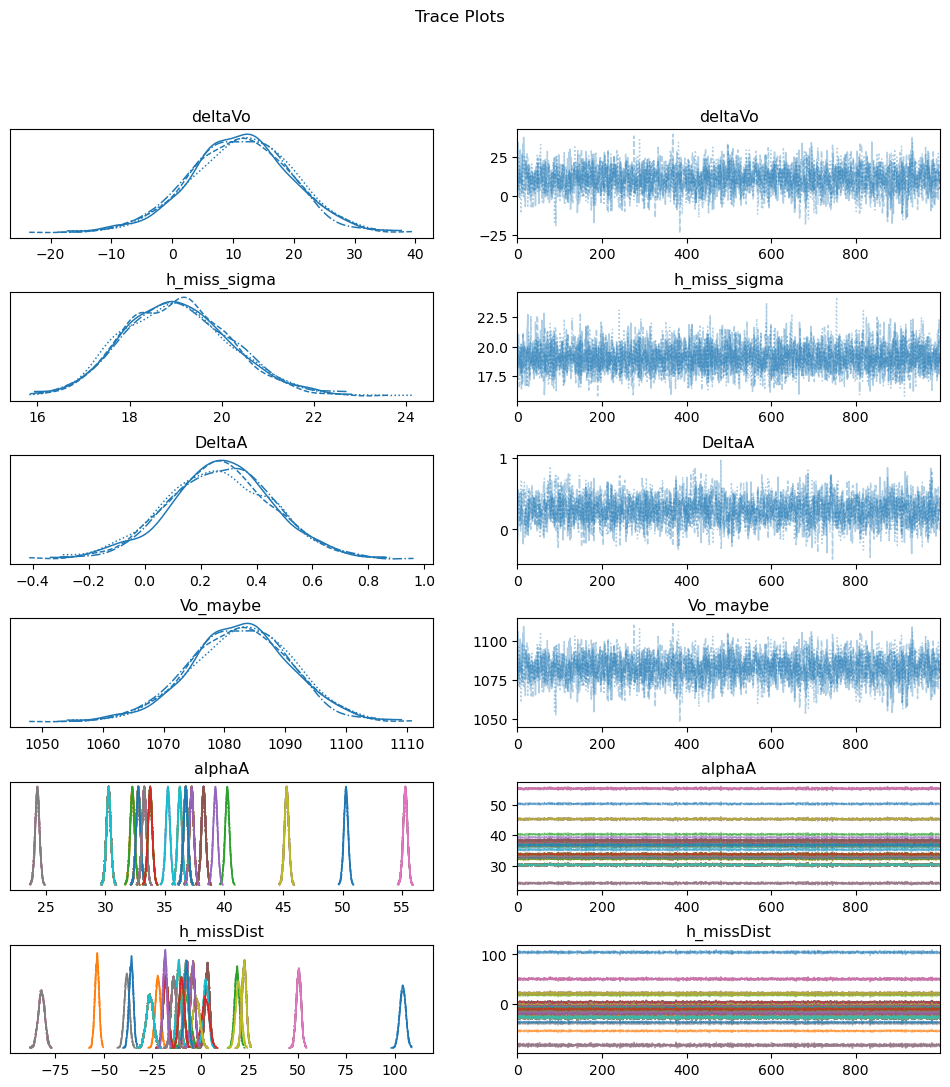

In [39]:
az.plot_trace(idata)
plt.subplots_adjust( hspace=.5)
plt.suptitle("Trace Plots")



plt.show()


In [40]:
idata.extend(pm.sample_posterior_predictive(idata, model=generate))


Sampling: [h_miss]


In [41]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

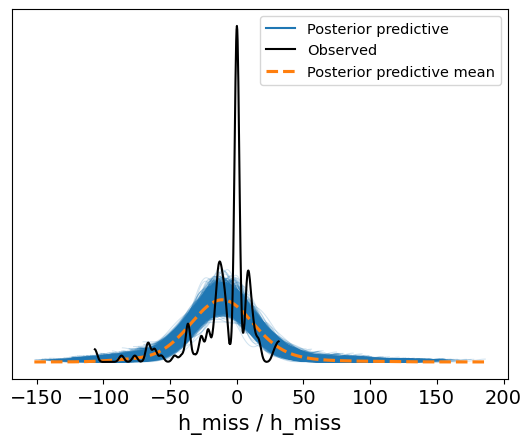

In [42]:
az.plot_ppc(idata, var_names=[ 'h_miss'])
plt.show()


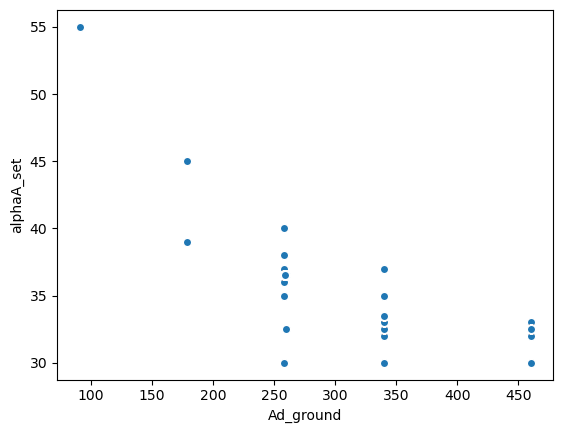

In [58]:

miss_tol = 5
idata.constant_data[['Ad_ground', 'alphaA_set']].where(abs(idata.posterior_predictive.h_miss)<miss_tol).plot.scatter(x='Ad_ground', y='alphaA_set')
